In [1]:
%pylab nbagg
%load_ext Cython

Populating the interactive namespace from numpy and matplotlib


In [2]:
from math import sqrt
from numba import jit
@jit
def mandel_iter( re_c, im_c, niter ):
    # Appartenance au disque C0{(0,0),1/4} ou Mandelbrot converge
    if ( re_c*re_c + im_c*im_c < 0.0625 ):
        return niter
    # Appartenance au disque C1{(-1,0),1/4} ou Mandelbrot converge
    if ( (re_c+1)*(re_c+1)+im_c*im_c < 0.0625 ):
        return niter
    # Appartenance a la cardioide {(1/4,0),1/2(1-cos(theta))}
    if ( re_c > -0.75 ) and ( re_c < 0.75 ) :
        re_ct = re_c - 0.25
        im_ct = im_c
        ctnrm2 = sqrt(re_ct*re_ct+im_ct*im_ct)
        if (ctnrm2 < 0.5*(1-re_ct/ctnrm2)):
           return niter;
    re_z = 0.
    im_z = 0.
    it   = 0
    while ( re_z*re_z+im_z*im_z < 4 ) and (it < niter ) :
        t    = re_z*re_z - im_z * im_z + re_c
        im_z = 2*re_z*im_z + im_c
        re_z = t
        it += 1
    return it

def comp_mandelbrot( res_x, res_y, depth_per_color ):
    img = np.zeros((res_y,res_x,3),np.float64)
    max_iter = 2**(depth_per_color*3)
    print("maxiter = {}".format(max_iter))
    msk = 2**depth_per_color - 1
    scaleX   = 3./(res_x-1)
    scaleY   = 2.25/(res_y-1)
    for j in range(res_y):
        im_c = -1.125 + j * scaleY
        for i in range(res_x):
            re_c = -2. + i*scaleX
            nit  = mandel_iter( re_c, im_c, max_iter )
            img[j,i,0] = ((max_iter - nit) & msk)/(1.*msk)
            img[j,i,1] = (((max_iter - nit )>>depth_per_color) & msk)/(1.*msk)
            img[j,i,2] = (((max_iter - nit )>>(2*depth_per_color)) & msk)/(1.*msk)
    return img


<IPython.core.display.Javascript object>


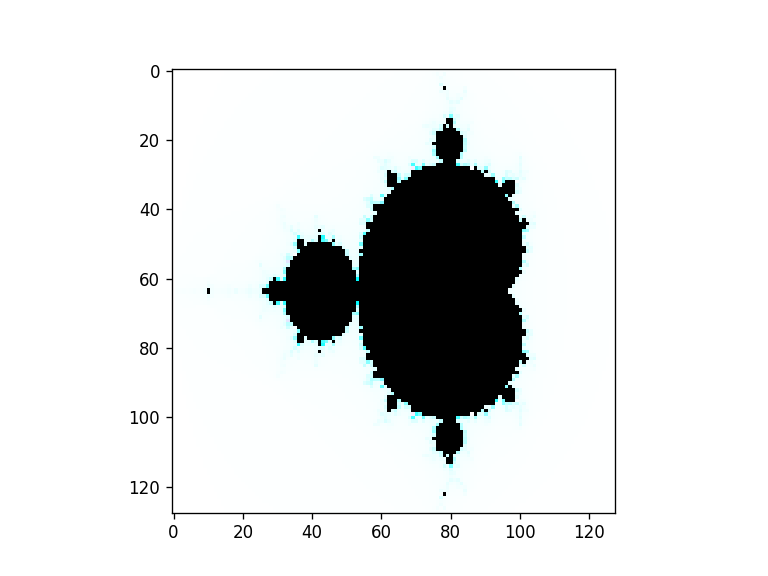

maxiter = 16777216
CPU times: user 21 s, sys: 8 ms, total: 21 s
Wall time: 21 s


In [3]:
f,ax = subplots()
%time res = comp_mandelbrot( 128, 128, 8)
ax.imshow(res)

In [4]:
%%cython -a

import cython
import numpy as np
from libc.math cimport sqrt
#from math import sqrt

@cython.cdivision(True)
def mandel_iter_cy1(double re_c, double im_c, int niter ):
    cdef:
        double ctnrm2, re_z, im_z
        int it
    # Appartenance au disque C0{(0,0),1/4} ou Mandelbrot converge
    if ( re_c*re_c + im_c*im_c < 0.0625 ):
        return niter
    # Appartenance au disque C1{(-1,0),1/4} ou Mandelbrot converge
    if ( (re_c+1)*(re_c+1)+im_c*im_c < 0.0625 ):
        return niter
    # Appartenance a la cardioide {(1/4,0),1/2(1-cos(theta))}
    if ( re_c > -0.75 ) and ( re_c < 0.75 ) :
        re_ct = re_c - 0.25
        im_ct = im_c
        ctnrm2 = sqrt(re_ct*re_ct+im_ct*im_ct)
        if (ctnrm2 < 0.5*(1-re_ct/ctnrm2)):
           return niter;
    re_z = 0.
    im_z = 0.
    it   = 0
    while ( re_z*re_z+im_z*im_z < 4 ) and (it < niter ) :
        t    = re_z*re_z - im_z * im_z + re_c
        im_z = 2*re_z*im_z + im_c
        re_z = t
        it += 1
    return it

def comp_mandelbrot_cy1( res_x, res_y, depth_per_color ):
    img = np.zeros((res_y,res_x,3),np.float64)
    max_iter = 2**(depth_per_color*3)
    print("maxiter = {}".format(max_iter))
    msk = 2**depth_per_color - 1
    scaleX   = 3./(res_x-1)
    scaleY   = 2.25/(res_y-1)
    for j in range(res_y):
        im_c = -1.125 + j * scaleY
        for i in range(res_x):
            re_c = -2. + i*scaleX
            nit  = mandel_iter_cy1( re_c, im_c, max_iter )
            img[j,i,0] = ((max_iter - nit) & msk)/(1.*msk)
            img[j,i,1] = (((max_iter - nit )>>depth_per_color) & msk)/(1.*msk)
            img[j,i,2] = (((max_iter - nit )>>(2*depth_per_color)) & msk)/(1.*msk)
    return img


<IPython.core.display.Javascript object>


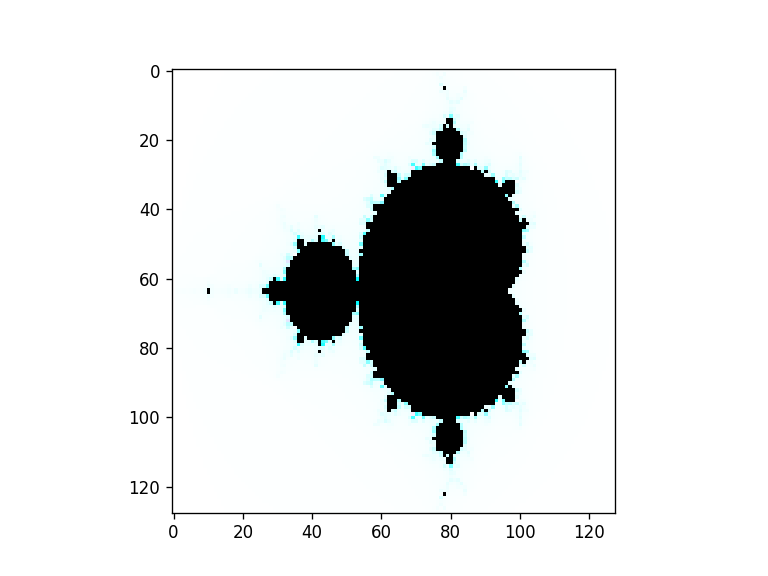

maxiter = 16777216
CPU times: user 21.3 s, sys: 160 ms, total: 21.4 s
Wall time: 21.4 s


In [5]:
f,ax = subplots()
%time res = comp_mandelbrot_cy1( 128, 128, 8)
ax.imshow(res)

In [6]:
src = """
static int mandel_iter( float re_c, float im_c, int niter )
{
    // Appartenance au disque C0{(0,0),1/4} ou Mandelbrot converge
    if ( re_c*re_c + im_c*im_c < 0.0625f )
        return niter;
    //Appartenance au disque C1{(-1,0),1/4} ou Mandelbrot converge
    if (((re_c+1)*(re_c+1)+im_c*im_c) < 0.0625 )
        return niter;
    // Appartenance a la cardioide {(1/4,0),1/2(1-cos(theta))}
    if (( re_c > -0.75 ) && ( re_c < 0.75 ))
    {
        float re_ct = re_c - 0.25f;
        float im_ct = im_c;
        float ctnrm2 = sqrt(re_ct*re_ct+im_ct*im_ct);
        if (ctnrm2 < (0.5f*(1-re_ct/ctnrm2)))
           return niter;
    }
    float re_z = 0.0f;
    float im_z = 0.0f;
    int it = 0;
    float t;
    while (( re_z*re_z+im_z*im_z < 4.0f ) && (it < niter ))
    {
        t    = re_z*re_z - im_z * im_z + re_c;
        im_z = 2*re_z*im_z + im_c;
        re_z = t;
        it += 1;
    }
    return it;
}

kernel void mandelbrot(int depth_per_color, global float *img)
{
    int j = get_global_id(1);
    int i = get_global_id(0);
    int res_x = get_global_size(0);
    int res_y = get_global_size(1);
    int pos = 3*(res_x*j+i);
    int max_iter = 1<<(depth_per_color*3);
    int msk = 1<<(depth_per_color - 1);
    float scaleX   = 3.0f/(res_x-1);
    float scaleY   = 2.25f/(res_y-1);
    float im_c = -1.125f + j * scaleY;
    float re_c = -2.0f + i*scaleX;
    int nit  = mandel_iter( re_c, im_c, max_iter );
    img[pos] = ((max_iter - nit) & msk)/(1.*msk);
    img[pos+1] = (((max_iter - nit )>>depth_per_color) & msk)/(1.*msk);
    img[pos+2] = (((max_iter - nit )>>(2*depth_per_color)) & msk)/(1.*msk);
}
"""

In [7]:
res_y = 128
res_x = 128
import numpy
import pyopencl, pyopencl.array
import os
os.environ["PYOPENCL_CTX"] = "2"
os.environ["PYOPENCL_COMPILER_OUTPUT"] = "1"
ctx = pyopencl.create_some_context()
print(ctx)
queue = pyopencl.CommandQueue(ctx)
img = numpy.zeros((res_y, res_x, 3), numpy.float32)
prg = pyopencl.Program(ctx, src).build()

def mandel_ocl(res_x, res_y, depth_per_color):
    img_d = pyopencl.array.empty(queue, (res_y, res_x, 3), dtype=numpy.float32)
    evt = prg.mandelbrot(queue, (res_x, res_y), (1,1), numpy.int32(depth_per_color), img_d.data)
    print(evt)
    evt.wait()
    print("done")
    return img_d.get()


<pyopencl.Context at 0x55e49079bf30 on <pyopencl.Device 'Intel(R) Core(TM) i5-4308U CPU @ 2.80GHz' on 'AMD Accelerated Parallel Processing' at 0x55e49050cc40>>


<IPython.core.display.Javascript object>


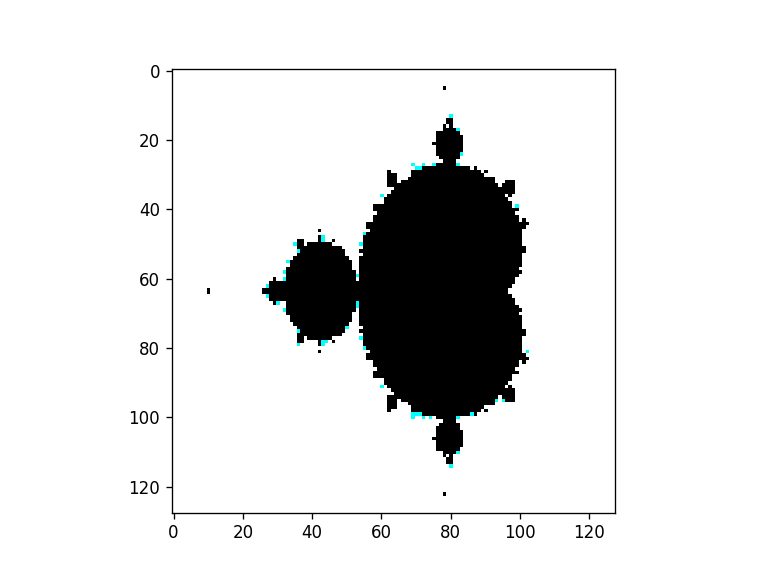

done
CPU times: user 23.8 s, sys: 80 ms, total: 23.9 s
Wall time: 6.81 s


In [8]:
f,ax = subplots()
%time res = mandel_ocl( 128, 128, 8)
ax.imshow(res)